# Digital Media Store Sales Analysis
This project is centered on analyzing a relational database storing a digital media store's product, customer, employee, and transaction information. Relevant information will be queried from the database using SQL, and visualized in order to answer the following questions:
- Which albums should be purchased in the future to retain or improve sales?
- Which employees generate the most sales? How does this compare to other employees?
- Which countries have the most potential for growth in sales?
- Do more customers purchase whole albums, or collections of one or more individual tracks?

The database storing the business' data follows the schema illustrated below:

![Database Schema](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

In [2]:
## HELPER FUNCTIONS
# Runs sql query and returns dataframe
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

# Executes an sql command
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
# Calls run_query() to return a list of tables & views
def show_tables():
    st = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(st)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting New Albums to Purchase
To select new albums the American store should purchase in the future, the number of sales associated with each genre will be determined. This will allow the store to make informed decisions with regards to which types of albums should be added to retain or improve sales, while retaining flexibility in choice.

In [4]:
# Return each genre with number / percentage of track sold in the USA
numTracksByGenre = '''
WITH usa_tracks_sold AS 
    (
    SELECT
        g.name AS genre,
        il.quantity AS quantity
    FROM track AS t
    INNER JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = 'USA' 
    )

SELECT
    uts.genre AS genre,
    SUM(uts.quantity) AS tracks_sold,
    CAST(SUM(uts.quantity) AS FLOAT) / (SELECT COUNT(*) FROM usa_tracks_sold) AS percentage_sold
FROM usa_tracks_sold AS uts
GROUP BY genre
ORDER BY tracks_sold DESC;
'''

run_query(numTracksByGenre)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


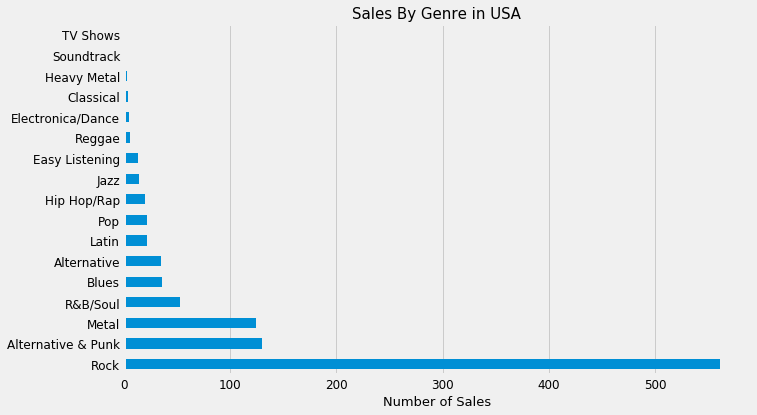

In [5]:
tracksByGenre = run_query(numTracksByGenre)
tracksByGenre.set_index("genre", inplace=True, drop=True)
tracksByGenre.index.name = ''

style.use('fivethirtyeight')
tracksByGenre['tracks_sold'].plot.barh(figsize=(10,6), fontsize=12)
plt.xlabel('Number of Sales', fontsize=13)
plt.title('Sales By Genre in USA', fontsize=15)
ax = plt.gca()
ax.yaxis.grid(False)
plt.show()

Based on the number of sales by genre, there is more incentive to select rock, punk, metal, and R&B/Soul albums. Since rock encompasses more that 50% of the total sales, acquiring more albums from rock artists should be prioritized in the USA.

## Analyzing Employee Sales Performance
Since each customer from the store is assigned to a sales support agent, we will analyze the purchases of customers belonging to each employee. This will help to identify which agents are underperforming or overperforming relative to the others.

In [6]:
# Query total dollar amount of sales and hire date assigned to each sales support agent.
emp_perf = '''
WITH cust_invoices AS (
    SELECT 
        c.customer_id,
        SUM(i.total) customer_total,
        c.support_rep_id
    FROM invoice i
    LEFT JOIN customer AS c ON i.customer_id = c.customer_id
    GROUP BY c.customer_id
    ORDER BY c.customer_id
    )
    
SELECT
    ci.support_rep_id,
    e.first_name || ' ' || e.last_name AS employee_name,
    SUM(ci.customer_total) AS total_sales,
    e.hire_date
FROM cust_invoices AS ci
LEFT JOIN employee e ON e.employee_id = ci.support_rep_id
GROUP BY ci.support_rep_id
ORDER BY total_sales DESC
'''

run_query(emp_perf)

,support_rep_id,employee_name,total_sales,hire_date
0,3,Jane Peacock,1731.51,2017-04-01 00:00:00
1,4,Margaret Park,1584.00,2017-05-03 00:00:00
2,5,Steve Johnson,1393.92,2017-10-17 00:00:00


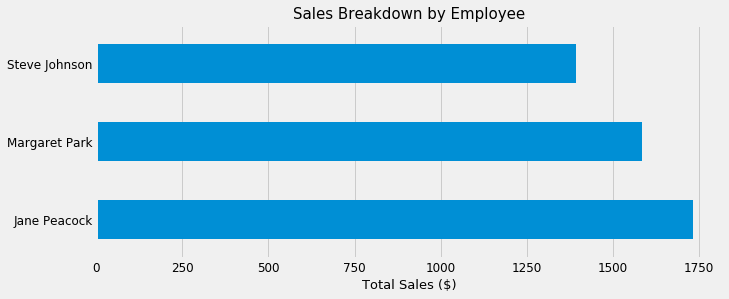

In [7]:
employeePerf = run_query(emp_perf)
employeePerf = employeePerf[['employee_name','total_sales']]
employeePerf.set_index('employee_name', inplace=True, drop=True)

employeePerf['total_sales'].plot.barh(figsize=(10,4), fontsize=12)
plt.xlabel('Total Sales ($)', fontsize=13)
plt.ylabel('')
plt.title('Sales Breakdown by Employee', fontsize=15)
ax = plt.gca()
ax.yaxis.grid(False)
plt.show()

It is clear that Jane performed the best in terms of sales, followed by Margaret, then Steve. This can be possibly attributed to amount of job experience based on their hiring dates. Jane was hired for the longest, and Steve, the shortest.

## Analyzing Sales by Country
To analyze the sales by country, we will query the total number of customers, total value of sales, average value of sales per customer, and average order value for each country.

Results will be sorted by total sales in descending order. Countries that only have one customer will be aggregated into an "Other" group, placed at the bottom.

In [8]:
countrySales = '''
WITH country_info AS (
    SELECT
        c.country,
        COUNT(DISTINCT i.customer_id) AS num_customers,
        SUM(i.total) AS total_sales,
        SUM(i.total) / COUNT(DISTINCT i.customer_id) AS avg_sale_per_customer,
        AVG(i.total) AS avg_order
    FROM invoice i
    LEFT JOIN customer c ON c.customer_id = i.customer_id
    GROUP BY c.country
    ),

other_countries AS (
    SELECT 
        CASE
            WHEN ci.num_customers = 1 THEN 'Other'
            ELSE ci.country
        END AS country,
        ci.num_customers,
        ci.total_sales,
        ci.avg_sale_per_customer,
        ci.avg_order
    FROM country_info ci           
    )

SELECT
    country,
    SUM(num_customers) AS num_customers,
    SUM(total_sales) AS total_sales,
    AVG(avg_sale_per_customer) AS avg_sale_per_customer,
    AVG(avg_order) AS avg_order
FROM
    (
    SELECT
        oc.*,
        CASE
            WHEN oc.country = 'Other' THEN 1
            ELSE 0
        END AS sort
    FROM other_countries oc
    )
GROUP BY country
ORDER BY sort ASC, total_sales DESC;

'''

run_query(countrySales)

,country,num_customers,total_sales,avg_sale_per_customer,avg_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.445071


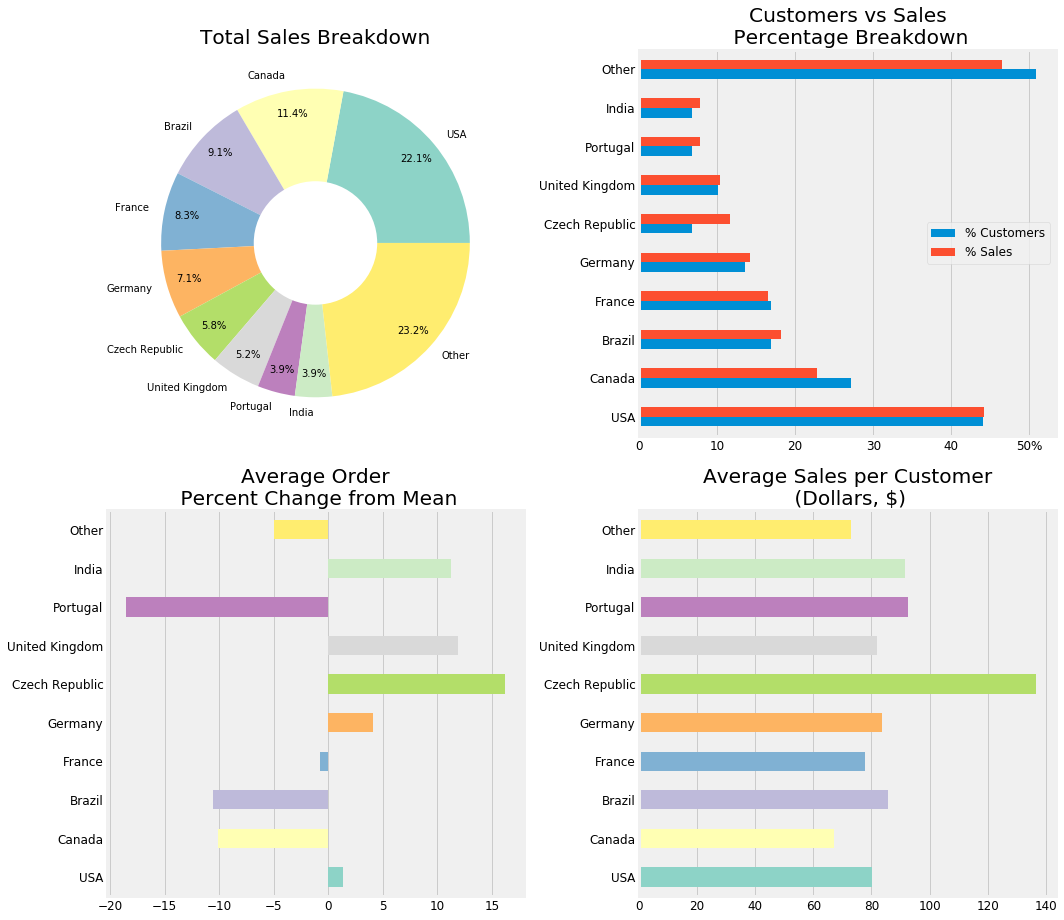

In [9]:
country_sales = run_query(countrySales)
country_sales.set_index('country' ,inplace=True)

# Visualizing Sales by Country
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
fig.set_facecolor('white')

# Top Left - proportion of total sales
country_sales.plot.pie(
    y='total_sales',
    title='Total Sales Breakdown',
    ax=axes[0,0],
    legend = False,
    autopct='%1.1f%%',
    textprops={'fontsize': 10, 'color': 'k'}, 
    pctdistance=0.85, 
    labeldistance=1.1,
    cmap = 'Set3'
)
centre_circle = plt.Circle((0,0),0.40,fc='white')
axes[0,0].add_artist(centre_circle)
axes[0,0].axis('off')

# Top Right - customer % and sale %
cust_sale_pct = country_sales[['num_customers', 'total_sales']].copy()
cust_sale_pct['num_customers'] = cust_sale_pct['num_customers'] / cust_sale_pct['num_customers'].sum() * 100
cust_sale_pct['total_sales'] = cust_sale_pct['total_sales'] / cust_sale_pct['total_sales'].sum() * 100
cust_sale_pct.rename(columns={'num_customers': '% Customers', 'total_sales': '% Sales'}, inplace=True)
cust_sale_pct.index.rename('', inplace=True)
cust_sale_pct.plot.barh(
    ax=axes[0,1],
    title='Customers vs Sales\n Percentage Breakdown'
)
axes[0,1].yaxis.grid(False)
axes[0,1].set_xticklabels(labels = ['0', '10', '20', '30', '40', '50%'])
axes[0,1].yaxis.set_tick_params(labelsize=12)
axes[0,1].xaxis.set_tick_params(labelsize=12)
axes[0,1].legend(prop={"size":12})

# Bottom Left - Average Order (Percent Difference from mean)
avg_orders = country_sales[['avg_order']].copy()
mean_avg_order = avg_orders['avg_order'].mean()
avg_orders['order_pct_change'] = (avg_orders['avg_order'] / mean_avg_order - 1) * 100
avg_orders.index.rename('', inplace=True)
colors = [plt.cm.Set3(i) for i in np.linspace(0, 1, country_sales.shape[0])]
avg_orders.plot.barh(
    ax=axes[1,0],
    y='order_pct_change',
    title='Average Order\n Percent Change from Mean',
    legend=False,
    color=colors
)
axes[1,0].yaxis.grid(False)
axes[1,0].yaxis.set_tick_params(labelsize=12)
axes[1,0].xaxis.set_tick_params(labelsize=12)

# Bottom Right - Average Sale ($) per Customer
country_sales.plot.barh(
    ax=axes[1,1],
    y='avg_sale_per_customer',
    title='Average Sales per Customer\n (Dollars, $)',
    legend=False,
    color=colors
)
axes[1,1].yaxis.grid(False)
axes[1,1].set_ylabel('')
axes[1,1].yaxis.set_tick_params(labelsize=12)
axes[1,1].xaxis.set_tick_params(labelsize=12)
fig.tight_layout() # so subplots don't overlap
plt.show()

From the sales metrics of countries presented, it is evident that the USA accounts for the greatest percentage of sales and customers, which makes sense since the media store is currently based in the USA. 

Outside of the USA, the Czech Republic makes a good candidate for new advertising campaigns since the country generates the most money per customer. Other potential candidates for marketing abroad are India, as well as the United Kingdom.

## Albums vs Individual Track Sales
Next, we will determine the proportion customer transactions which constitute the purchase of whole albums, versus those which consist of collections of individual tracks.

In [10]:
alb_trks = '''
WITH invoice_ref_track AS
    (
    SELECT
        il.invoice_id,
        MIN(il.track_id) ref_track
    FROM invoice_line il
    GROUP BY il.invoice_id
    )

SELECT
    is_album,
    COUNT(invoice_id) AS num_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice_ref_track) AS percent_invoices
FROM(
    SELECT
        irt.invoice_id,
        irt.ref_track,
        CASE
            WHEN
                (
                SELECT t.track_id
                FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id
                                    FROM track t2
                                    WHERE t2.track_id = irt.ref_track
                                    )

                EXCEPT

                SELECT il.track_id
                FROM invoice_line il
                WHERE il.invoice_id = irt.invoice_id
                )IS NULL
            AND
                (
                SELECT il.track_id
                FROM invoice_line il
                WHERE il.invoice_id = irt.invoice_id

                EXCEPT

                SELECT t.track_id
                FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id
                                    FROM track t2
                                    WHERE t2.track_id = irt.ref_track
                                    )

                )IS NULL
            THEN "yes"
            ELSE "no"       
        END AS is_album
    FROM invoice_ref_track AS irt)
GROUP BY is_album;
'''

run_query(alb_trks)

,is_album,num_invoices,percent_invoices
0,no,500,0.814332
1,yes,114,0.185668


Based on the query above, it is apparent that most of the sales result from customers purchasing a collection of individual tracks (81%), rather than an entire album.

## Conclusion
Based on the results of our analysis, we've determined the following from querying a digital media store's database:
- The purchase of rock, punk, metal, and R&B/Soul albums should be prioritized, especially rock albums since more than 50% of individual sales are of this genre.
- Jane performs the best in terms of generating sales, followed by Margaret, then Steve.
- Marketing outside of the USA should be focused on the Czech Republic, India, and the UK.
- 81% of customer transactions consist of a collection of individual track purchases, rather than whole album purchases.

The results of this analysis could be used by management to make more informed business decisions in the future.